**Variable Utility is not Intrinsic**

There is much ado about variable selection or variable utility valuation in supervised machine learning. In this note we will try to disarm some possibly common fallacies, and to set reasonable expectations about how variable valuation can work.

## Introduction

In general variable valuation is estimating the utility that a column of explanatory values `x` will have in predicting a column of dependent values `y`. It is quantifying the strength of the relation between `x` and `y`. If this were asked in isolation, this would be easy (essentially just compute something like a correlation). However, this is usually asked in the context of more than one possible explanatory variable and a variety of possible modeling strategies.

In our opinion, variable valuation and selection is an often necessary step. It is useful when your machine learning modeling is in danger of being overwhelmed by values in irrelevant columns (such as our [Bad Bayes examples](https://win-vector.com/2014/02/01/bad-bayes-an-example-of-why-you-need-hold-out-testing/)). These situations
often arise in practice in data science projects, as data scientists are often using wide tables or data-marts with hundreds of columns
that were designed for many users. Such tables often have many columns that are not in, a statistical sense, useful variables for a given task.

One might argue it is unlikely there are hundreds of causal columns for a given project. And this is likely true. However,
for many data science projects we are attempting to estimate `P[y = True]` from side-effects or correlated-attribute columns, and it is  typical for an online record keeping system to have hundreds of these columns and attributes. Thus it is common to work with many columns, many being relevant variables and many not.

Our stance is: we need variable valuation, but we can't lean on it too hard. Roughly, variable valuation is not well founded, unless stated with respect to a given generative model, data set, model fitting procedure, and even a given model. This is why our `vtreat` variable preparation package ([`vtreat` for Python here](https://github.com/WinVector/pyvtreat), [`vtreat` for `R` here](https://github.com/WinVector/vtreat)) package defers on the issue, and uses only simple linear methods for *light variable screening* (delete as few variables as possible, and have the option to not even do that).

What a variable is worth, unfortunately, depends on who is asking.

## Practical Solutions

In our opinion the most successful variable valuation tools are the permutation importance tests (such as those found in random forest and `xgboost`) that compute the utility of a variable with respect to a single fit model. They do this by damaging the variable, and seeing how the fixed model predictions then degrade. Useless variables inflict little damage, critical variables inflict a lot of damage.

These solutions are very usable, efficient, and give good practical advice. Furthermore, they give, in addition to a useful variable ranking, a quantified value for each variable (how much quality the model loses if lied to about the values of the variable in question).

However, these methods *are* measuring the value of variable *with respect to a single, already fit model*. So they are possibly not measuring intrinsic variable importance or even true variable importance with respect to a single model fitting procedure.

To emphasize: estimating the practical *posterior utility* of a variable in a project is a *solved* problem. Mere practitioners, such as myself, routinely do this to great benefit. What we are arguing is we can't expect completely reliable domain agnostic hands-off *prior utility* estimates. So, we routinely use context dependent estimates.

## Examples and Issues

Let's make the issue concrete by working a few examples. I find it amazing how people are expected to spend hundreds of hours learning grand frameworks, yet not a few minutes working a few small examples.

### Duplicate Variables

The first issue with a possible theory of intrinsic variable importance is: the issue of duplicate columns in a data store. If two columns are identical then it is literally impossible to determine from data which one is intrinsically more important than the other.

For example: if we delete one such column from a data store, we can still fit the equivalent of any model we could have before. It is hard to argue fully replaceable variables are uniquely essential. So from a model-fitting perspective duplicate columns are a fundamental issue.

### Cooperating Variables

It has long been known that sometimes variables are not usable on their own, but can combine with or synergize with (perhaps in the form of what is called an interaction) to produce useful variables and models. The classic example is `xor` which we will represent as multiplying numbers chosen from the set `{-1, 1}`. Let's work this example in [`Python`](https://www.python.org).

First we attach our packages.

In [1]:
import numpy
import pandas
import sklearn.linear_model
import sklearn.tree
import sklearn.feature_selection

Now we show a data frame where each of our two variables appear to be individually useless in predicting the value of `y`.

In [2]:
d_joint = pandas.DataFrame({
  'x1': (    1,     -1,    1,   -1),
  'x2': (   -1,      1,    1,   -1),
  'y':  (False,  False, True, True)
})

d_joint

,x1,x2,y
0,1,-1,False
1,-1,1,False
2,1,1,True
3,-1,-1,True


We see each variable is individually of no value, as the conditional distribution of `y` is identical for all values of any one of these variables. We confirm this here.

In [3]:
pandas.crosstab(
    d_joint.y,
    d_joint.x1
)

x1,-1,1
y,,
False,1,1
True,1,1


In [4]:
pandas.crosstab(
  d_joint.y,
  d_joint.x2)

x2,-1,1
y,,
False,1,1
True,1,1


We can see these variables are very useful jointly. Let's build an interaction derived variable out of them.

In [5]:
d_joint['x1_x2'] = d_joint.x1 * d_joint.x2

Notice this derived variable completely determines `y`.

In [6]:
pandas.crosstab(
  d_joint.y,
  d_joint.x1_x2)

x1_x2,-1,1
y,,
False,2,0
True,0,2


This "variables only work together" is enough to fool many variable selectors. For example we show `sklearn.feature_selection.mutual_info_classif` below, which appears to feel the variables are not useful and returns small noisy estimates of their value.

In [7]:
d_joint_large = pandas.concat([d_joint] * 1000)

[sklearn.feature_selection.mutual_info_classif(
    X = d_joint_large.loc[:, ['x1', 'x2']],
    y = d_joint_large.y) for i in range(10)]

[array([0.        , 0.00603286]),
 array([0.00063293, 0.        ]),
 array([0.00013784, 0.00504526]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0.00202637, 0.        ]),
 array([0.01523189, 0.        ]),
 array([0.00622672, 0.        ]),
 array([0, 0])]

### Dependence on Modeling Method

Given the difficulty in evaluating variables alone, let's try evaluating them in groups. The obvious tool for combining sets of variables is a machine learning or statistical model.

That is in fact the case. We will now show an example where which variables are selected (or valued above zero) depends on the modeling method.

For this example, let's set up some data. Again the task is to predict `y` knowing the `x`s.

In [8]:
d_test = pandas.DataFrame({
  'x1': (3,  3, -2, -2, -2,  2,  2,  2, -3, -3),
  'x2': (0,  0,  0,  0,  0,  1,  0,  0,  0,  0),
  'x3': (0,  0,  0,  0,  0,  0,  1,  0,  0,  0),
  'x4': (0,  0,  0,  0,  0,  0,  0,  1,  0,  0),
  'x5': (0,  0,  0,  0,  0,  0,  0,  0,  1,  0),
  'x6': (0,  0,  0,  0,  0,  0,  0,  0,  0,  1),
  'y': ([False] * 5) + ([True] * 5)})

d_test

,x1,x2,x3,x4,x5,x6,y
0,3,0,0,0,0,0,False
1,3,0,0,0,0,0,False
2,-2,0,0,0,0,0,False
3,-2,0,0,0,0,0,False
4,-2,0,0,0,0,0,False
5,2,1,0,0,0,0,True
6,2,0,1,0,0,0,True
7,2,0,0,1,0,0,True
8,-3,0,0,0,1,0,True
9,-3,0,0,0,0,1,True


We build a larger data set that is just a number of copies of the first. This is to have enough data to run the `rpart` training procedure with default [hyper parameters](https://win-vector.com/2021/01/08/the-hyper-dance/).

In [9]:
d_train = pandas.concat([d_test] * 100)

d_train.shape

(1000, 7)

#### Regularized Generalized Linear Model

Let's use try fitting a regularized logistic regression on this data.

In [10]:
vars = ('x1', 'x2', 'x3', 'x4', 'x5', 'x6')

rlm = sklearn.linear_model.LogisticRegression().fit(
  X = d_train.loc[:, vars],
  y = d_train.y)

We get a perfect model that represents `y` as a linear function of some of the `x`s.

In [11]:
rlm.predict_proba(d_test.loc[:, vars])

array([[0.94364021, 0.05635979],
       [0.94364021, 0.05635979],
       [0.94364021, 0.05635979],
       [0.94364021, 0.05635979],
       [0.94364021, 0.05635979],
       [0.05635977, 0.94364023],
       [0.05635977, 0.94364023],
       [0.05635977, 0.94364023],
       [0.05635977, 0.94364023],
       [0.05635977, 0.94364023]])

It is easy to look at the coefficients (or "parameters") of this model.

In [12]:
rlm_coef = pandas.DataFrame({'coefficient': rlm.coef_[0, :]})
rlm_coef.index = vars

rlm_coef

,coefficient
x1,-2.292542e-18
x2,5.635978e+00
x3,5.635978e+00
x4,5.635978e+00
x5,5.635978e+00
x6,5.635978e+00


In [13]:
rlm_vars = list(set(rlm_coef.index[numpy.abs(rlm_coef.iloc[:, 0]) >= 1.e-12]))
rlm_vars.sort()

rlm_vars

['x2', 'x3', 'x4', 'x5', 'x6']

Notice, the variable `x1` is not used. The liner fitting method considers it to not be of value. We will return to this in our next subsection.

#### Tree Based Model

We can fit the same data using a tree based model.

In [14]:
tm = sklearn.tree.DecisionTreeClassifier().fit(
  X = d_train.loc[:, vars],
  y = d_train.y)


Again, we get a perfect model.

In [15]:
tm.predict_proba(d_test.loc[:, vars])

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

Notice *only* the variable `x1` is used, even though all variables were made available.

[Text(111.60000000000001, 190.26, 'X[0] <= -2.5\ngini = 0.5\nsamples = 1000\nvalue = [500, 500]'),
 Text(55.800000000000004, 135.9, 'gini = 0.0\nsamples = 200\nvalue = [0, 200]'),
 Text(167.4, 135.9, 'X[0] <= 0.0\ngini = 0.469\nsamples = 800\nvalue = [500, 300]'),
 Text(111.60000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 300\nvalue = [300, 0]'),
 Text(223.20000000000002, 81.53999999999999, 'X[0] <= 2.5\ngini = 0.48\nsamples = 500\nvalue = [200, 300]'),
 Text(167.4, 27.180000000000007, 'gini = 0.0\nsamples = 300\nvalue = [0, 300]'),
 Text(279.0, 27.180000000000007, 'gini = 0.0\nsamples = 200\nvalue = [200, 0]')]

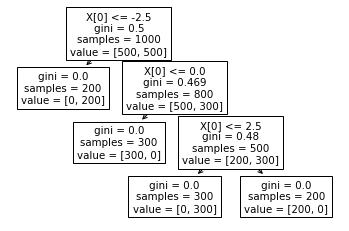

In [16]:
sklearn.tree.plot_tree(tm)

In [17]:
tree_importance = pandas.DataFrame({'importance': tm.feature_importances_})
tree_importance.index = vars

tree_importance

,importance
x1,1.0
x2,0.0
x3,0.0
x4,0.0
x5,0.0
x6,0.0


In [18]:
tree_vars = list(set(tree_importance.index[tree_importance.iloc[:, 0] != 0]))
tree_vars.sort()

tree_vars

['x1']

#### Comparing Modeling Methods

Note that the linear method said `x1` *is not* an important variable, yet the tree based method said `x1` *is* an important variable. This argues against `x1` having a simple intrinsic value independent of modeling method.

There *is* a intrinsic metric available via algorithmic information theory, which we will quickly discuss in the next section.

## Algorithmic Information Theory

A way to eliminate context in variable evaluation: assume one can enumerate out all possible contexts. I.e. a set of variables is useful if there is *any* possible model that can use them effectively. This essentially gets you to algorithmic information theory (the essentially un-realizable Solomonoff–Kolmogorov–Chaitin complexity variation). Unfortunately this also is not actionable as you typically don't have enough power to compute the value of variable in this way. Also even if an external system informed you of the intrinsic information content of the variables, you may not be able to use such advice, unless this oracle also supplied witnessing transformations and fit models.

## Conclusion

The need and desire for a simple practical intrinsic measure of variable importance, or variable utility, is legitimate and strong. Variable value can at best be calculated with respect to context. Context includes what other variables are present, the modeling procedure, and sometimes a specific already fit model.

The above example problems *are* just toys. We are not truly concerned that these examples might be problems. The concern is: these issue can be lurking in real data sets.

Our advice is: use simple variable screening methods, and do not invest in large theoretical frameworks. If some fraction of variable importance doesn't depend on context, then even estimating it in a context (as random forest and `xgboost` do) will be useful.

It would be nice if there were frameworks that relieved the data scientist of being responsible for making the right decisions in the face of insufficient context and evidence. However, that can not always be the case.
